In [1]:
#import libraries and such
import os
import numpy as np
from scipy import integrate, linalg
from matplotlib import pyplot as py

%matplotlib inline

In [2]:
#load geometry from data file
naca_filepath = os.path.join('naca0012.dat')
with open(naca_filepath, 'r') as infile:
    x, y = np.loadtxt(infile, dtype=float, unpack=True)

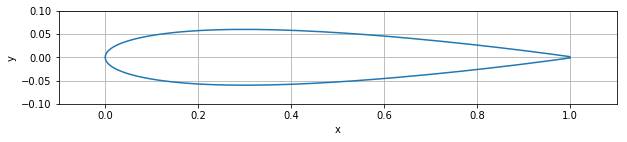

In [3]:
#plot airfoil geometry
width = 10
py.figure(figsize=(width, width))
py.grid()
py.xlabel('x')
py.ylabel('y')
py.plot(x, y)
py.axis('scaled', adjustable='box')
py.xlim(-0.1, 1.1)
py.ylim(-0.1, 0.1);

In [4]:
#now, we create our class Panel that stores all information
#about one panel.

class Panel:
    
    def __init__(self, xa, ya, xb, yb):
        
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2 #panel center
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2) #panel length
        
        # orientation of panel
        if xb - xa <= 0.0:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)
            
        # panel location
        if self.beta <= np.pi:
            self.loc = 'upper' #upper surface
        else:
            self.loc = 'lower' #lower surface
            
        self.sigma = 0.0 #source strength
        self.vt = 0.0 #tangent velocity
        self.cp = 0.0 #pressure coeff

In [5]:
def define_panels(x, y, N=40):
    
    R = (x.max() - x.min()) / 2.0 #circle radius
    x_center = (x.max() + x.min()) / 2.0 # x-coord of circle center
    
    theta = np.linspace(0.0, 2.0 * np.pi, N + 1) #array of angles
    x_circle = x_center + R * np.cos(theta) #x-coord of circle
    
    x_ends = np.copy(x_circle) #x-coord of panels end points
    y_ends = np.empty_like(x_ends) #y-coord of panels end-points
    
    # extend coordinates to consider closed surface
    x, y = np.append(x, x[0]), np.append(y, y[0])
    
    #compute y-coord of end-points by projections
    I = 0
    for i in range(N):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    panels = np.empty(N, dtype = object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i +1])
        
    return panels

In [6]:
# discretize geometry into panels
panels = define_panels(x, y, N = 40)

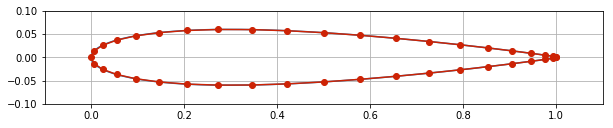

In [7]:
# plot discretized geometry
width = 10
py.figure(figsize=(width, width))
py.grid()
py.plot(x, y)
py.plot(np.append([panel.xa for panel in panels], panels[0].xa),
        np.append([panel.ya for panel in panels], panels[0].ya),
       color='#CD2305', marker='o')
py.axis('scaled', adjustable='box')
py.xlim(-0.1, 1.1)
py.ylim(-0.1, 0.1);

In [8]:
# now we create our freestream class to pass to other functions
# later on
class Freestream:
    
    def __init__(self, u_inf=1.0, alpha=0.0):
        
        self.u_inf = u_inf
        self.alpha = np.radians(alpha) #degrees to radians

In [9]:
# define freestream conditions
freestream = Freestream(u_inf=1.0, alpha = 4.0)

In [10]:
#now, we can build the linear system to solve for our strength
# and circulation values

def integral(x, y, panel, dxdk, dydk):
    
    def integrand(s):
        return(((x - (panel.xa - np.sin(panel.beta) * s)) * dxdk + 
                (y - (panel.ya + np.cos(panel.beta) * s)) * dydk) /
               ((x - (panel.xa - np.sin(panel.beta) * s))**2 +
                (y - (panel.ya + np.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]
    

In [11]:
# now we need a function to build the source matric:
# the affect of each source on the normal velocity of each panel

def source_contribution_normal(panels):
    
    A = np.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    np.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(panel_i.xc, panel_i.yc,
                                                 panel_j,
                                                 np.cos(panel_i.beta),
                                                 np.sin(panel_i.beta))
    return A

In [12]:
# then, we define a function to build the vortex matrix
def vortex_contribution_normal(panels):
    
    A = np.empty((panels.size, panels.size), dtype=float)
    #vortex contribution on a panel from itself
    np.fill_diagonal(A, 0.0)
    #vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / np.pi * integral(panel_i.xc, panel_i.yc,
                                                  panel_j,
                                                  np.sin(panel_i.beta),
                                                  -np.cos(panel_i.beta))
    return A

In [13]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

In [14]:
#now we have to satisfy the cutta condition
def kutta_condition(A_source, B_vortex):
    
    b = np.empty(A_source.shape[0] + 1, dtype = float)
    
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    
    b[-1] = - np.sum(A_source[0, :] + A_source[-1, :])
    return b

In [15]:
# this next function will gather together the source matrix,
# the vortex array, and the kutta array to build the matrix 
# needed to solve the linear system.

In [16]:
def build_singularity_matrix(A_source, B_vortex):
    
    A = np.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype=float)
    #source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = np.sum(B_vortex, axis=1)
    #kutta condition array
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

In [17]:
#on the right hand side, we store everything that does
# not depend on the unknown strengths
def build_freestream_rhs(panels, freestream):
    
    b = np.empty(panels.size + 1, dtype=float)

    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    b[-1] = -freestream.u_inf * (np.sin(freestream.alpha - panels[0].beta) +
                                 np.sin(freestream.alpha - panels[-1].beta))
    return b

In [18]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)

In [19]:
# now we can solve the linear system using linalg solve
# then we store the results in the attribute sigma of each
# Panel object. 
# we also create a variable gamma to store value of constant
# vortex strength

In [20]:
strengths = np.linalg.solve(A, b)

#store source strength on each panel
for i, panel in enumerate(panels):
    panel.sigma = strengths[i]
    
#store circulation density
gamma = strengths[-1]

In [21]:
# now to deal with the pressure coefficient, we compute the
# tangential velocity at each panel center

def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    
    A = np.empty((panels.size, panels.size + 1), dtype=float)
    
    A[:, :-1] = B_vortex
    
    A[:, -1] = -np.sum(A_source, axis=1)
    
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta for panel in panels])
    
    strengths = np.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panels in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [22]:
# tangential velocity at each panel center.
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)

In [23]:
def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

In [24]:
compute_pressure_coefficient(panels, freestream)

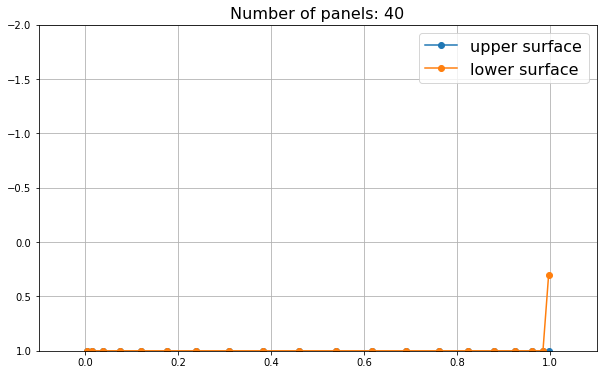

In [25]:
#plot surface pressure coefficient
py.figure(figsize=(10, 6))
py.grid()
py.plot([panel.xc for panel in panels if panel.loc == 'upper'],
        [panel.cp for panel in panels if panel.loc == 'upper'],
        label='upper surface', marker = 'o')
py.plot([panel.xc for panel in panels if panel.loc == 'lower'],
        [panel.cp for panel in panels if panel.loc == 'lower'],
        label = 'lower surface', marker = 'o')
py.legend(loc='best', prop={'size':16})
py.xlim(-0.1, 1.1)
py.ylim(1.0, -2.0)
py.title('Number of panels: {}'.format(panels.size), fontsize=16);


